
从 `item_properties_part1.csv` 与 `item_properties_part2.csv` 过滤出 `property == "categoryid"` 的记录。
保留所有 `categoryid` 记录（最新时间戳），仅按 `itemid` 进行 inner join；属性侧时间戳保留为 `category_timestamp`。
与 `events.csv` 以 `itemid` 做 inner join，得到带分类的事件数据。结果保存为 `./events_with_category.csv` 

In [ ]:
import pandas as pd

event_f = pd.read_csv('./events.csv')
item1_f = pd.read_csv('./item_properties_part1.csv')
item2_f = pd.read_csv('./item_properties_part2.csv')

print(event_f.shape)
print(item1_f.shape)
print(item2_f.shape)

# 检查item中同一个itemid在不同的timestamp下对应的categoryid是否一致
items = pd.concat([item1_f, item2_f], ignore_index=True)
print('合并后 items 维度:', items.shape)

category_items = items[items['property'] == 'categoryid'][['itemid', 'value']].drop_duplicates()
# rename value to categoryid
category_items = category_items.rename(columns={'value': 'categoryid'})
print('category_items 维度:', category_items.shape)

# category_items 和 events 进行 inner join on itemid
merged = event_f.merge(category_items, on='itemid', how='inner')
print('merged 维度:', merged.shape)
print('merged 示例:')
print(merged.head(10))


(2756101, 5)
(10999999, 4)
(9275903, 4)
合并后 items 维度: (20275902, 4)
category_items 维度: (442432, 2)
merged 维度: (2709446, 6)
merged 示例:
       timestamp  visitorid event  itemid  transactionid categoryid
0  1433221332117     257597  view  355908            NaN       1173
1  1433224214164     992329  view  248676            NaN       1231
2  1433221955914     483717  view  253185            NaN        914
3  1433221337106     951259  view  367447            NaN       1613
4  1433221337106     951259  view  367447            NaN        491
5  1433224086234     972639  view   22556            NaN       1074
6  1433221923240     810725  view  443030            NaN       1098
7  1433223291897     794181  view  439202            NaN       1542
8  1433220899221     824915  view  428805            NaN        646
9  1433221204592     339335  view   82389            NaN       1404


In [2]:
# check transactionid null ratio
null_ratio = merged['transactionid'].isnull().mean()
print(f'transactionid null ratio: {null_ratio:.2%}')
# delete transactionid column
merged = merged.drop(columns=['transactionid'])

transactionid null ratio: 99.14%


In [ ]:
merged['timestamp'] = pd.to_datetime(merged['timestamp'], unit='ms')
print(merged.head(10))
merged.to_csv('./events_with_category.csv', date_format='%Y-%m-%d %H:%M:%S', index=False)

                timestamp  visitorid event  itemid categoryid
0 2015-06-02 05:02:12.117     257597  view  355908       1173
1 2015-06-02 05:50:14.164     992329  view  248676       1231
2 2015-06-02 05:12:35.914     483717  view  253185        914
3 2015-06-02 05:02:17.106     951259  view  367447       1613
4 2015-06-02 05:02:17.106     951259  view  367447        491
5 2015-06-02 05:48:06.234     972639  view   22556       1074
6 2015-06-02 05:12:03.240     810725  view  443030       1098
7 2015-06-02 05:34:51.897     794181  view  439202       1542
8 2015-06-02 04:54:59.221     824915  view  428805        646
9 2015-06-02 05:00:04.592     339335  view   82389       1404


In [4]:
# event type 的分布
event_type_counts = merged['event'].value_counts(normalize=True) * 100
print('Event Type Distribution (%):')
print(event_type_counts)

# 总的不同 visitorid 数量
total_visitors = merged['visitorid'].nunique()
print(f'Total unique visitors: {total_visitors}')

# event == addtocart 的记录中，不同 visitorid 的唯一数量
addtocart_visitors = merged[merged['event'] == 'addtocart']['visitorid'].nunique()
print(f'Unique visitors with addtocart: {addtocart_visitors}')

# event == transaction 的记录中，不同 visitorid 的唯一数量
transaction_visitors = merged[merged['event'] == 'transaction']['visitorid'].nunique()
print(f'Unique visitors with transactions: {transaction_visitors}')

# 有加购行为的 visitorid 占总 visitorid 的比例
addtocart_visitor_ratio = (addtocart_visitors / total_visitors) * 100
print(f'Add to cart visitor ratio: {addtocart_visitor_ratio:.2f}%')

# 有购买行为的 visitorid 占总 visitorid 的比例
purchase_visitor_ratio = (transaction_visitors / total_visitors) * 100
print(f'Purchase visitor ratio: {purchase_visitor_ratio:.2f}%')

# 有购买行为的 visitorid 占加购 visitorid 的比例
purchase_visitor_ratio = (transaction_visitors / addtocart_visitors) * 100
print(f'Purchase visitor ratio (of add to cart): {purchase_visitor_ratio:.2f}%')

Event Type Distribution (%):
event
view           96.419785
addtocart       2.717714
transaction     0.862501
Name: proportion, dtype: float64
Total unique visitors: 1236032
Unique visitors with addtocart: 37387
Unique visitors with transactions: 11569
Add to cart visitor ratio: 3.02%
Purchase visitor ratio: 0.94%
Purchase visitor ratio (of add to cart): 30.94%


In [5]:
# 总的不同 category 数量
total_categories = merged['categoryid'].nunique()
print(f'Total unique categories: {total_categories}')

# event == transaction 的记录中，不同 category 的唯一数量
transaction_categories = merged[merged['event'] == 'transaction']['categoryid'].nunique()
print(f'Unique categories with transactions: {transaction_categories}')

# 有购买行为的 category 占总 category 的比例
purchase_category_ratio = (transaction_categories / total_categories) * 100
print(f'Purchase category ratio: {purchase_category_ratio:.2f}%')


Total unique categories: 1156
Unique categories with transactions: 751
Purchase category ratio: 64.97%


In [6]:
# 不同月份的购买行为数量和他们对应占总购买行为的比例
merged['month'] = merged['timestamp'].dt.to_period('M')
monthly_transactions = merged[merged['event'] == 'transaction'].groupby('month').size()
print('Monthly Transactions:')
print(monthly_transactions)
monthly_transaction_ratio = (monthly_transactions / monthly_transactions.sum()) * 100
print('Monthly Transaction Ratios (%):')
print(monthly_transaction_ratio)


Monthly Transactions:
month
2015-05    4862
2015-06    5304
2015-07    5994
2015-08    4782
2015-09    2427
Freq: M, dtype: int64
Monthly Transaction Ratios (%):
month
2015-05    20.805340
2015-06    22.696735
2015-07    25.649365
2015-08    20.463007
2015-09    10.385554
Freq: M, dtype: float64


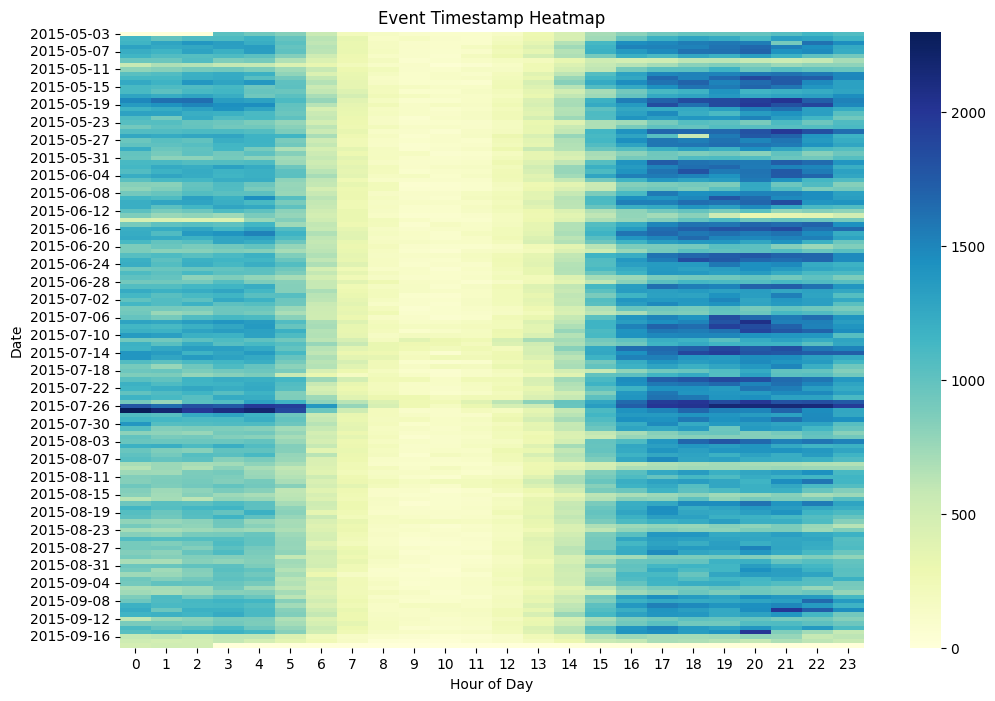

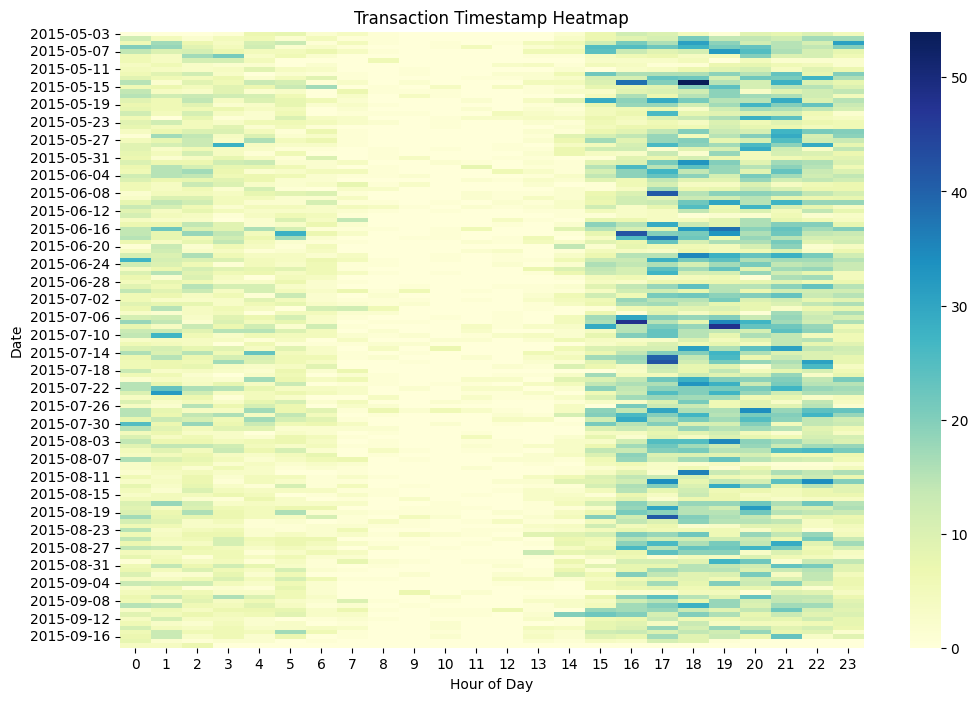

In [7]:
# 时间戳分布热力图
import matplotlib.pyplot as plt
import seaborn as sns
merged['date'] = merged['timestamp'].dt.date
merged['hour'] = merged['timestamp'].dt.hour
heatmap_data = merged.groupby(['date', 'hour']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('Event Timestamp Heatmap')
plt.xlabel('Hour of Day')
plt.ylabel('Date')
plt.show()

# 购买行为的时间戳分布热力图
transaction_data = merged[merged['event'] == 'transaction'].groupby(['date', 'hour']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(transaction_data, cmap='YlGnBu')
plt.title('Transaction Timestamp Heatmap') 
plt.xlabel('Hour of Day')
plt.ylabel('Date')
plt.show()  

In [8]:
# categoryid 的不重复值
unique_categories = merged['categoryid'].nunique()
print(f'Unique category IDs: {unique_categories}')

# itemid 的不重复值
unique_items = merged['itemid'].nunique()
print(f'Unique item IDs: {unique_items}')

# 每个 categoryid 下的 itemid 数量分布
category_item_counts = merged.groupby('categoryid')['itemid'].nunique()
print('Item counts per category ID:')
print(category_item_counts)

Unique category IDs: 1156
Unique item IDs: 185246
Item counts per category ID:
categoryid
0        95
1       641
10        1
100       6
1000      2
       ... 
992      30
996     198
997      66
998      84
999     453
Name: itemid, Length: 1156, dtype: int64


In [9]:
# 同一个vistorid对同一个itemid的event序列
grouped = merged.sort_values(by=['visitorid', 'itemid', 'timestamp']).groupby(['visitorid', 'itemid'])

# for (visitorid, itemid), group in grouped:
#     print(f'visitorid: {visitorid}, itemid: {itemid}')
#     print(group)



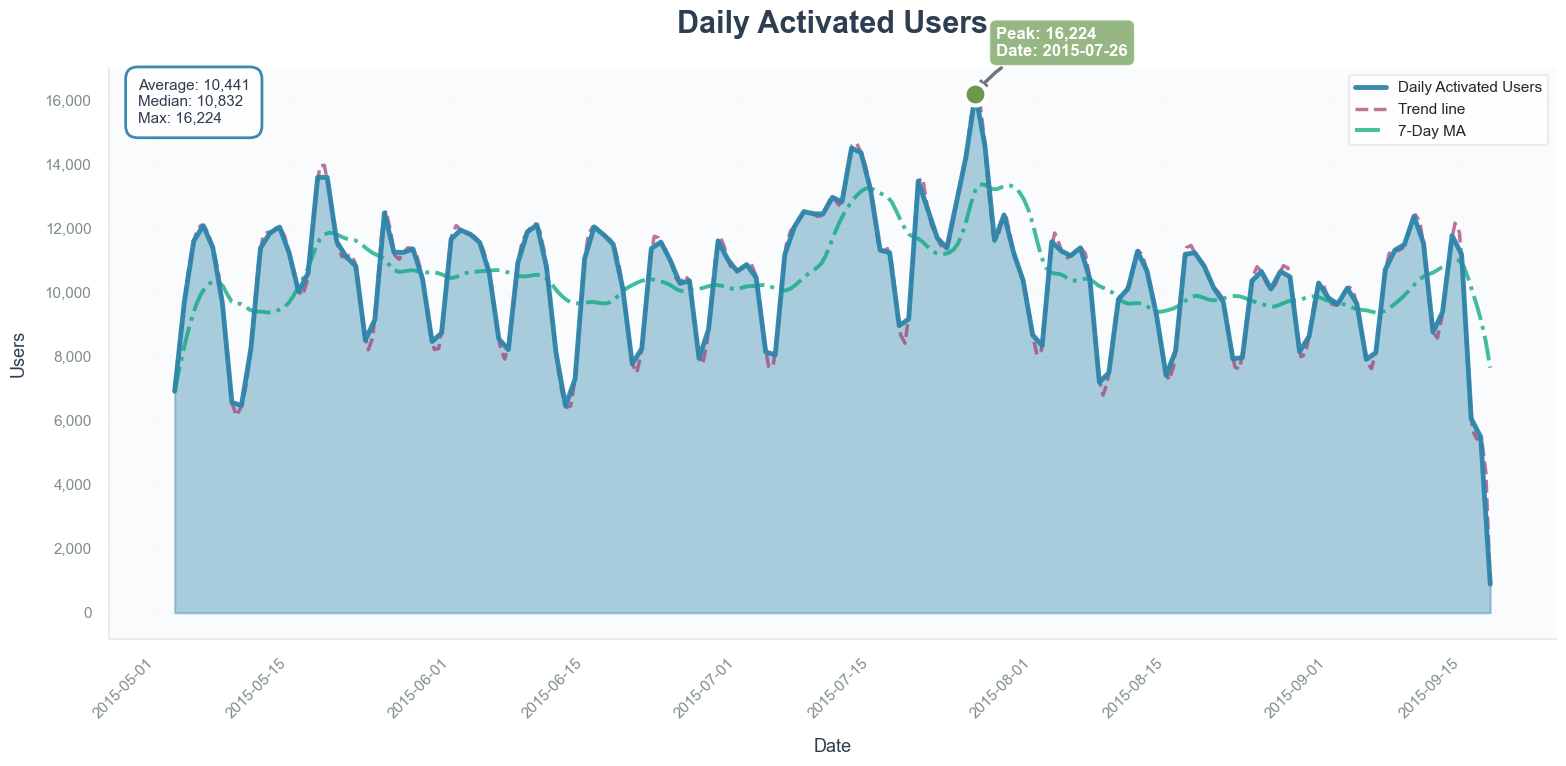

In [ ]:
# 用户活跃度与留存率可视化 - 优雅配色设计
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
from datetime import datetime

# 设置中文字体和现代化样式
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid", {'axes.grid': True, 'grid.alpha': 0.2})

# 确保数据已加载
if 'merged' not in locals():
    merged = pd.read_csv('./events_with_category.csv')
    merged['timestamp'] = pd.to_datetime(merged['timestamp'])

# 优雅的配色方案 - 参考Tableau和D3.js经典配色
COLORS = {
    'primary': '#2E86AB',        # 深海蓝
    'primary_light': '#A23B72',  # 深紫红
    'secondary': '#F18F01',      # 温暖橙
    'accent': '#C73E1D',         # 深红
    'success': '#6A994E',        # 森林绿
    'info': '#06A77D',           # 青绿
    'gradient_blue': ['#E8F4F8', '#B8E0E8', '#7FC8D8', '#4A9BC8', '#2E86AB'],
    'gradient_purple': ['#F5E6F0', '#E8C5D9', '#D4A5C2', '#B87BA3', '#A23B72'],
    'gradient_orange': ['#FFF4E6', '#FFE0B3', '#FFCC80', '#FFB84D', '#F18F01'],
    'bg': '#FFFFFF',
    'bg_light': '#FAFBFC',
    'text': '#2C3E50',
    'text_light': '#7F8C8D',
    'grid': '#E8ECEF'
}

# ==================== 1. 每日活跃用户数 (DAU) - 优雅设计 ====================
merged['date'] = merged['timestamp'].dt.date
daily_active_users = merged.groupby('date')['visitorid'].nunique().reset_index()
daily_active_users.columns = ['date', 'dau']
daily_active_users['date'] = pd.to_datetime(daily_active_users['date'])

fig, ax = plt.subplots(figsize=(16, 8), facecolor='white')
ax.set_facecolor(COLORS['bg_light'])

x = daily_active_users['date']
y = daily_active_users['dau']

# 使用优雅的蓝色渐变填充
ax.fill_between(x, y, alpha=0.4, color=COLORS['primary'], zorder=1)
ax.plot(x, y, linewidth=3.5, color=COLORS['primary'], alpha=0.95, zorder=3, label='Daily Activated Users')

# 添加平滑曲线
from scipy.interpolate import make_interp_spline
x_smooth = pd.date_range(x.min(), x.max(), periods=300)
y_smooth = make_interp_spline(range(len(x)), y, k=3)(np.linspace(0, len(x)-1, 300))
ax.plot(x_smooth, y_smooth, linewidth=2.5, color=COLORS['primary_light'], alpha=0.7, linestyle='--', zorder=2, label='Trend line')

# 绘制 dau 7日滑动平均
daily_active_users['dau_7d_ma'] = daily_active_users['dau'].rolling(7, min_periods=1).mean()
y_ma_smooth = make_interp_spline(
    range(len(daily_active_users)),
    daily_active_users['dau_7d_ma'],
    k=3
)(np.linspace(0, len(daily_active_users)-1, 300))
ax.plot(
    x_smooth,
    y_ma_smooth,
    linewidth=2.8,
    color=COLORS['info'],
    alpha=0.75,
    linestyle='-.',
    label='7-Day MA',
    zorder=2
)


# 标注最大值
max_idx = y.idxmax()
peak_date = x.iloc[max_idx]
peak_value = y.iloc[max_idx]
date_str = peak_date.strftime('%Y-%m-%d')
ax.scatter(peak_date, peak_value, s=250, color=COLORS['success'], 
          zorder=5, edgecolors='white', linewidths=3)
ax.annotate(f'Peak: {peak_value:,.0f}\nDate: {date_str}', 
           xy=(peak_date, peak_value),
           xytext=(15, 25), textcoords='offset points',
           bbox=dict(boxstyle='round,pad=0.4', facecolor=COLORS['success'], 
                    alpha=0.7, edgecolor='white', linewidth=1),
           fontsize=12, fontweight='bold', color='white',
           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', 
                          color=COLORS['text'], lw=2.5, alpha=0.7),
           ha='left',  # 左对齐
           va='bottom')  # 底部对齐


# 美化坐标轴
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(COLORS['grid'])
ax.spines['bottom'].set_color(COLORS['grid'])
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax.tick_params(colors=COLORS['text_light'], labelsize=11)
ax.grid(True, alpha=0.15, linestyle='-', linewidth=0.8, color=COLORS['grid'])

# 标题和标签
ax.set_title('Daily Activated Users', fontsize=22, fontweight='600', 
            color=COLORS['text'], pad=25)
ax.set_xlabel('Date', fontsize=13, color=COLORS['text'], fontweight='500', labelpad=12)
ax.set_ylabel('Users', fontsize=13, color=COLORS['text'], fontweight='500', labelpad=12)

# 添加统计信息
stats_text = f'Average: {y.mean():,.0f}\nMedian: {y.median():,.0f}\nMax: {y.max():,.0f}'
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
       fontsize=11, verticalalignment='top',
       bbox=dict(boxstyle='round,pad=0.8', facecolor='white', alpha=0.95, 
                edgecolor=COLORS['primary'], linewidth=2),
       color=COLORS['text'])

ax.legend(loc='upper right', fontsize=11, framealpha=0.95, edgecolor=COLORS['grid'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

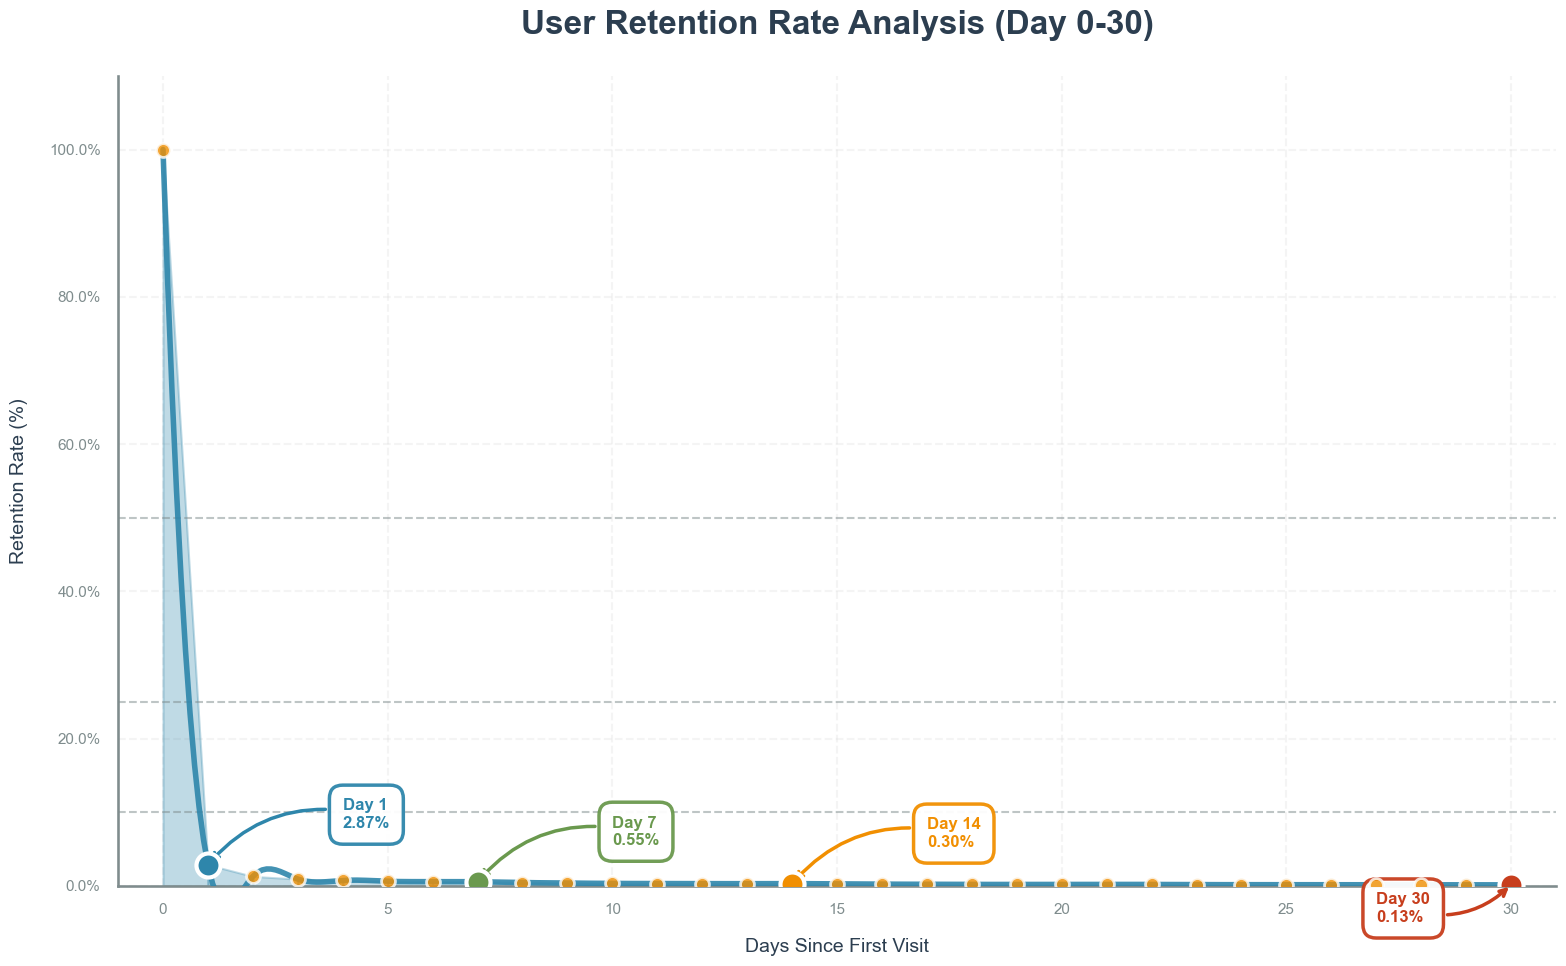


📈 关键留存率指标:
  Day  1:   2.87% (35,452.0 用户)
  Day  7:   0.55% ( 6,820.0 用户)
  Day 14:   0.30% ( 3,681.0 用户)
  Day 30:   0.13% ( 1,562.0 用户)


In [36]:
# ==================== 3. 用户留存率曲线 - 精美设计 ====================
# 计算每个用户的首次访问日期
user_first_visit = merged.groupby('visitorid')['timestamp'].min().reset_index()
user_first_visit.columns = ['visitorid', 'first_visit_date']
user_first_visit['first_visit_date'] = pd.to_datetime(user_first_visit['first_visit_date']).dt.date

# 合并首次访问日期
merged_with_first = merged.copy()
merged_with_first['visit_date'] = pd.to_datetime(merged_with_first['timestamp']).dt.date
merged_with_first = merged_with_first.merge(user_first_visit, on='visitorid', how='left')
merged_with_first['first_visit_date'] = pd.to_datetime(merged_with_first['first_visit_date'])
merged_with_first['visit_date'] = pd.to_datetime(merged_with_first['visit_date'])
merged_with_first['days_since_first'] = (merged_with_first['visit_date'] - merged_with_first['first_visit_date']).dt.days

# 计算留存率
retention_data = []
for day in range(0, 31):
    if day == 0:
        daily_new = merged_with_first[merged_with_first['days_since_first'] == 0].groupby('visit_date')['visitorid'].nunique()
        total_new = daily_new.sum()
        retention_data.append({'day': day, 'users': total_new, 'retention_rate': 100.0})
    else:
        daily_retained = merged_with_first[merged_with_first['days_since_first'] == day]['visitorid'].nunique()
        retention_rate = (daily_retained / total_new) * 100 if total_new > 0 else 0
        retention_data.append({'day': day, 'users': daily_retained, 'retention_rate': retention_rate})

retention_df = pd.DataFrame(retention_data)

# 创建精美的留存率图表
fig, ax1 = plt.subplots(figsize=(16, 10), facecolor='white')
ax1.set_facecolor(COLORS['bg'])

# 绘制渐变填充区域
x = retention_df['day']
y = retention_df['retention_rate']

# 创建渐变填充
for i in range(len(x)-1):
    alpha_val = 0.3 - (i / len(x)) * 0.2  # 渐变透明度
    ax1.fill_between([x.iloc[i], x.iloc[i+1]], 
                     [y.iloc[i], y.iloc[i+1]], 
                     alpha=alpha_val, 
                     color=COLORS['primary'])

# 绘制主曲线（带平滑）
from scipy.interpolate import make_interp_spline
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = make_interp_spline(x, y, k=3)(x_smooth)
ax1.plot(x_smooth, y_smooth, linewidth=4, color=COLORS['primary'], 
        alpha=0.9, zorder=3, label='Retention Rate Curve')

# 绘制原始数据点
ax1.scatter(x, y, s=100, color=COLORS['secondary'], zorder=4, 
           edgecolors='white', linewidths=2, alpha=0.8)

# 标注关键留存点
key_days = [1, 7, 14, 30]
key_colors = [COLORS['primary'], COLORS['success'], COLORS['secondary'], COLORS['accent']]
for day, color in zip(key_days, key_colors):
    if day < len(y):
        rate = y.iloc[day]
        ax1.scatter(day, rate, s=300, color=color, zorder=5, 
                   edgecolors='white', linewidths=3)
        ax1.annotate(f'Day {day}\n{rate:.2f}%', 
                    xy=(day, rate), 
                    xytext=(day+3 if day < 15 else day-3, rate+5 if day < 15 else rate-5),
                    fontsize=12, fontweight='bold', color=color,
                    bbox=dict(boxstyle='round,pad=0.8', facecolor='white', 
                            edgecolor=color, linewidth=2.5, alpha=0.95),
                    arrowprops=dict(arrowstyle='->', color=color, lw=2.5, 
                                  connectionstyle='arc3,rad=0.3'))

# 添加基准线
ax1.axhline(y=50, color=COLORS['text_light'], linestyle='--', linewidth=1.5, alpha=0.5, zorder=1)
ax1.axhline(y=25, color=COLORS['text_light'], linestyle='--', linewidth=1.5, alpha=0.5, zorder=1)
ax1.axhline(y=10, color=COLORS['text_light'], linestyle='--', linewidth=1.5, alpha=0.5, zorder=1)

# 美化坐标轴
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color(COLORS['text_light'])
ax1.spines['bottom'].set_color(COLORS['text_light'])

ax1.set_xlim(-1, 31)
ax1.set_ylim(0, max(y.max() * 1.1, 105))
ax1.set_xticks(range(0, 31, 5))
ax1.tick_params(colors=COLORS['text_light'], labelsize=11)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))

ax1.set_title('User Retention Rate Analysis (Day 0-30)', fontsize=24, fontweight='bold',
             color=COLORS['text'], pad=30)
ax1.set_xlabel('Days Since First Visit', fontsize=14, color=COLORS['text'], 
              fontweight='500', labelpad=15)
ax1.set_ylabel('Retention Rate (%)', fontsize=14, color=COLORS['text'], 
              fontweight='500', labelpad=15)
ax1.grid(True, alpha=0.2, linestyle='--', zorder=0)

plt.tight_layout()
plt.show()

# 打印关键指标
print('\n📈 关键留存率指标:')
for day in [1, 7, 14, 30]:
    if day < len(retention_df):
        rate = retention_df.iloc[day]['retention_rate']
        users = retention_df.iloc[day]['users']
        print(f'  Day {day:2d}: {rate:6.2f}% ({users:>8,} 用户)')

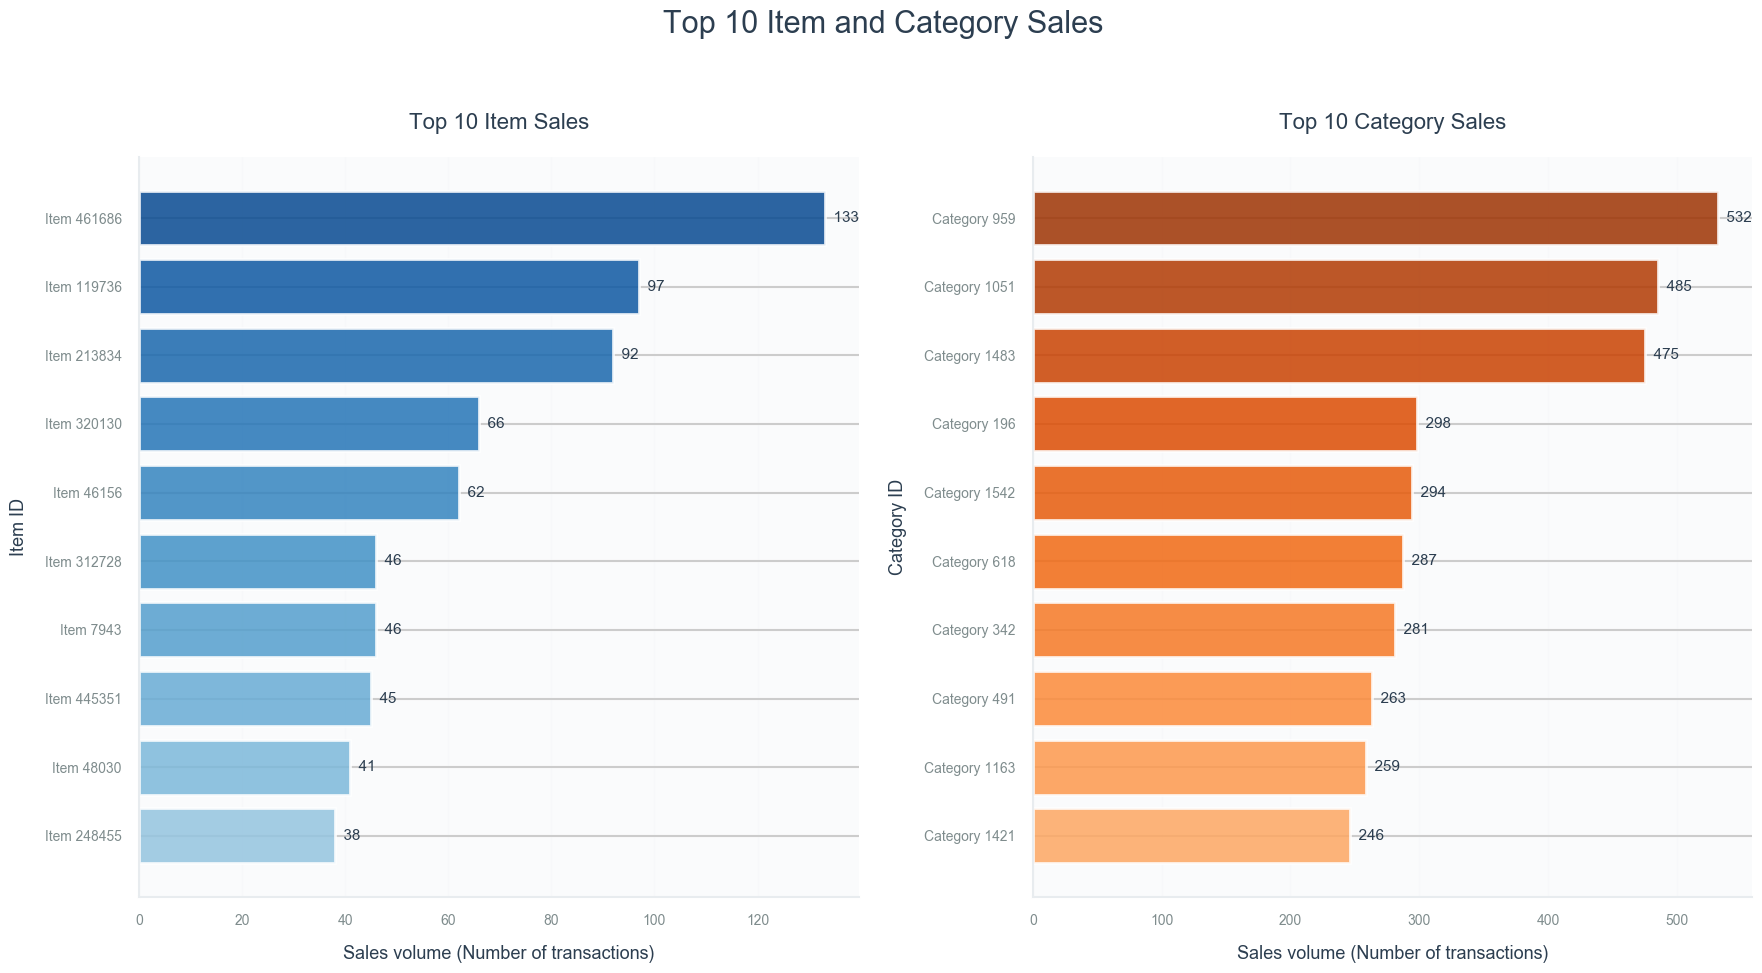


Top 10 Item Sales Statistics:
 itemid  sales_count
 461686          133
 119736           97
 213834           92
 320130           66
  46156           62
   7943           46
 312728           46
 445351           45
  48030           41
 248455           38

Top 10 Category Sales Statistics:
categoryid  sales_count
       959          532
      1051          485
      1483          475
       196          298
      1542          294
       618          287
       342          281
       491          263
      1163          259
      1421          246


In [ ]:
# 绘制按 ItemId 、categoryId 来的销量Top N （ 两个字图）

# 绘制按 ItemId 和 CategoryId 的销量 Top N
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 确保数据已加载
if 'merged' not in locals():
    merged = pd.read_csv('./events_with_category.csv')
    merged['timestamp'] = pd.to_datetime(merged['timestamp'])

# 设置中文字体和样式
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 优雅配色
COLORS = {
    'primary': '#2E86AB',
    'primary_light': '#A23B72',
    'secondary': '#F18F01',
    'accent': '#C73E1D',
    'success': '#6A994E',
    'info': '#06A77D',
    'bg': '#FFFFFF',
    'bg_light': '#FAFBFC',
    'text': '#2C3E50',
    'text_light': '#7F8C8D',
    'grid': '#E8ECEF'
}

# 设置 Top N 数量
TOP_N = 10

# 筛选交易数据（销量）
transactions = merged[merged['event'] == 'transaction'].copy()

# 1. 按 ItemId 统计销量
item_sales = transactions.groupby('itemid').size().reset_index(name='sales_count')
item_sales = item_sales.sort_values('sales_count', ascending=False).head(TOP_N)
item_sales = item_sales.sort_values('sales_count', ascending=True)  # 反转用于水平柱状图

# 2. 按 CategoryId 统计销量
category_sales = transactions.groupby('categoryid').size().reset_index(name='sales_count')
category_sales = category_sales.sort_values('sales_count', ascending=False).head(TOP_N)
category_sales = category_sales.sort_values('sales_count', ascending=True)  # 反转用于水平柱状图

# 创建两个并排的子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), facecolor='white')
fig.suptitle('Top 10 Item and Category Sales', fontsize=22, fontweight='600', color=COLORS['text'], y=0.98)

# ==================== 子图1: 按 ItemId 的销量 Top N ====================
ax1.set_facecolor(COLORS['bg_light'])

# 创建渐变色
colors_item = plt.cm.Blues(np.linspace(0.4, 0.9, len(item_sales)))

# 绘制水平柱状图
bars1 = ax1.barh(range(len(item_sales)), item_sales['sales_count'], 
                 color=colors_item, alpha=0.85, edgecolor='white', linewidth=2)

# 添加数值标签
for i, (idx, row) in enumerate(item_sales.iterrows()):
    ax1.text(row['sales_count'], i, f"  {int(row['sales_count'])}", 
            va='center', fontsize=11, fontweight='600', color=COLORS['text'])

# 设置y轴标签
ax1.set_yticks(range(len(item_sales)))
ax1.set_yticklabels([f"Item {int(item)}" for item in item_sales['itemid']], 
                    fontsize=10, color=COLORS['text'])

# 美化坐标轴
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color(COLORS['grid'])
ax1.spines['bottom'].set_color(COLORS['grid'])
ax1.spines['left'].set_linewidth(1.5)
ax1.spines['bottom'].set_linewidth(1.5)

ax1.set_xlabel('Sales volume (Number of transactions)', fontsize=13, color=COLORS['text'], 
              fontweight='500', labelpad=12)
ax1.set_ylabel('Item ID', fontsize=13, color=COLORS['text'], 
              fontweight='500', labelpad=12)
ax1.set_title(f'Top {TOP_N} Item Sales', fontsize=16, fontweight='600',
             color=COLORS['text'], pad=20)
ax1.grid(True, alpha=0.15, axis='x', linestyle='-', linewidth=0.8, color=COLORS['grid'])
ax1.tick_params(colors=COLORS['text_light'], labelsize=10)

# ==================== 子图2: 按 CategoryId 的销量 Top N ====================
ax2.set_facecolor(COLORS['bg_light'])

# 创建渐变色（使用不同的颜色方案）
colors_category = plt.cm.Oranges(np.linspace(0.4, 0.9, len(category_sales)))

# 绘制水平柱状图
bars2 = ax2.barh(range(len(category_sales)), category_sales['sales_count'], 
                 color=colors_category, alpha=0.85, edgecolor='white', linewidth=2)

# 添加数值标签
for i, (idx, row) in enumerate(category_sales.iterrows()):
    ax2.text(row['sales_count'], i, f"  {int(row['sales_count'])}", 
            va='center', fontsize=11, fontweight='600', color=COLORS['text'])

# 设置y轴标签
ax2.set_yticks(range(len(category_sales)))
ax2.set_yticklabels([f"Category {int(cat)}" for cat in category_sales['categoryid']], 
                    fontsize=10, color=COLORS['text'])

# 美化坐标轴
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_color(COLORS['grid'])
ax2.spines['bottom'].set_color(COLORS['grid'])
ax2.spines['left'].set_linewidth(1.5)
ax2.spines['bottom'].set_linewidth(1.5)

ax2.set_xlabel('Sales volume (Number of transactions)', fontsize=13, color=COLORS['text'], 
              fontweight='500', labelpad=12)
ax2.set_ylabel('Category ID', fontsize=13, color=COLORS['text'], 
              fontweight='500', labelpad=12)
ax2.set_title(f'Top {TOP_N} Category Sales', fontsize=16, fontweight='600',
             color=COLORS['text'], pad=20)
ax2.grid(True, alpha=0.15, axis='x', linestyle='-', linewidth=0.8, color=COLORS['grid'])
ax2.tick_params(colors=COLORS['text_light'], labelsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 打印统计信息
print(f'\nTop {TOP_N} Item Sales Statistics:')
print(item_sales.sort_values('sales_count', ascending=False).to_string(index=False))
print(f'\nTop {TOP_N} Category Sales Statistics:')
print(category_sales.sort_values('sales_count', ascending=False).to_string(index=False))


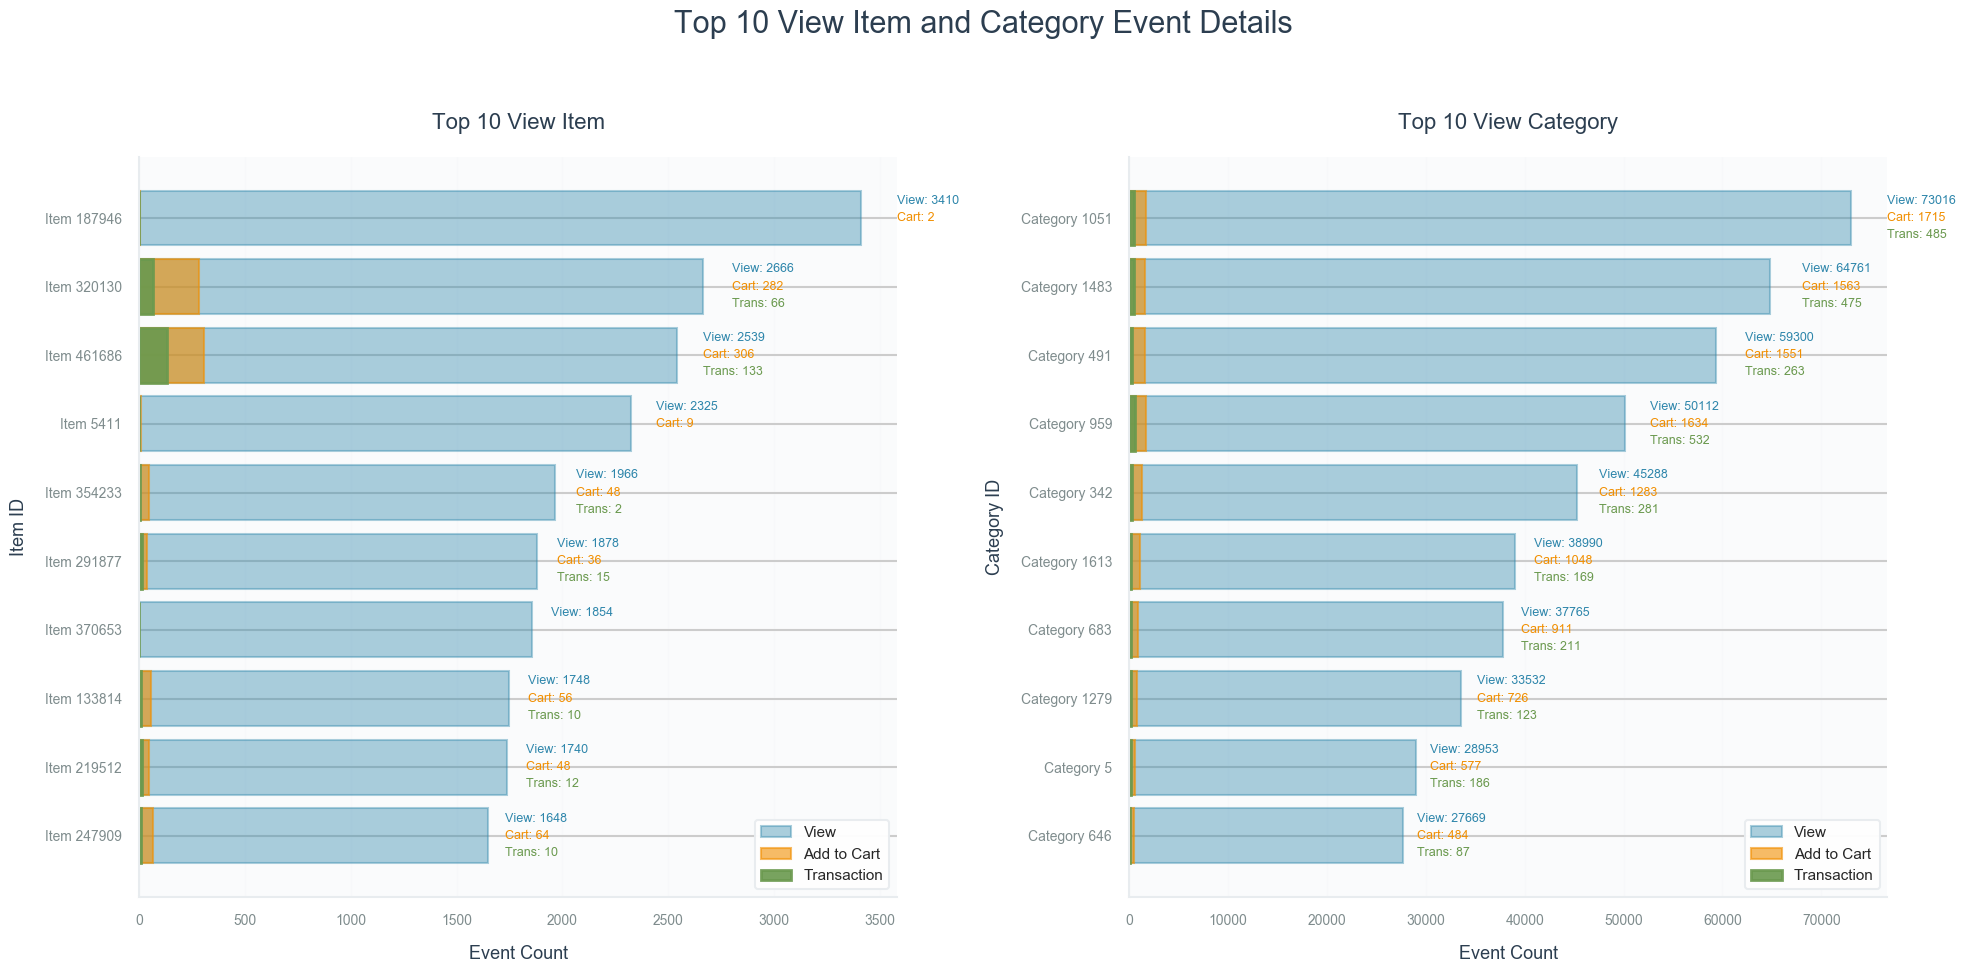


Top 10 View Item:
 itemid  view  addtocart  transaction
 187946  3410          2            0
 320130  2666        282           66
 461686  2539        306          133
   5411  2325          9            0
 354233  1966         48            2
 291877  1878         36           15
 370653  1854          0            0
 133814  1748         56           10
 219512  1740         48           12
 247909  1648         64           10

Top 10 View Category:
categoryid  view  addtocart  transaction
      1051 73016       1715          485
      1483 64761       1563          475
       491 59300       1551          263
       959 50112       1634          532
       342 45288       1283          281
      1613 38990       1048          169
       683 37765        911          211
      1279 33532        726          123
         5 28953        577          186
       646 27669        484           87

 Top N Item and Category Conversion Rate:

Top N Item Conversion Rate:
 itemid  view  ad

In [ ]:
# 绘制 Top N 浏览商品/品类及其对应的浏览、加购、交易次数（重叠柱状图）
# 三个柱子重叠显示，确保次数少的也能清晰看到
# 数值标签统一放在柱子右侧，按顺序排列
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 确保数据已加载
if 'merged' not in locals():
    merged = pd.read_csv('./events_with_category.csv')
    merged['timestamp'] = pd.to_datetime(merged['timestamp'])

# 设置中文字体和样式
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 优雅配色
COLORS = {
    'primary': '#2E86AB',
    'primary_light': '#A23B72',
    'secondary': '#F18F01',
    'accent': '#C73E1D',
    'success': '#6A994E',
    'info': '#06A77D',
    'bg': '#FFFFFF',
    'bg_light': '#FAFBFC',
    'text': '#2C3E50',
    'text_light': '#7F8C8D',
    'grid': '#E8ECEF',
    'view': '#2E86AB',        # 蓝色 - 浏览（最多，放底层）
    'addtocart': '#F18F01',   # 橙色 - 加购（中等，放中间）
    'transaction': '#6A994E'  # 绿色 - 交易（最少，放顶层）
}

# 设置 Top N 数量
TOP_N = 10

# ==================== 1. 按 ItemId 分析 ====================
# 找出浏览次数最多的 Top N 商品
item_views = merged[merged['event'] == 'view'].groupby('itemid').size().reset_index(name='view_count')
top_items = item_views.nlargest(TOP_N, 'view_count')['itemid'].tolist()

# 对每个 Top N 商品，统计三种事件的数量
item_stats = []
for itemid in top_items:
    item_data = merged[merged['itemid'] == itemid]
    stats = {
        'itemid': itemid,
        'view': len(item_data[item_data['event'] == 'view']),
        'addtocart': len(item_data[item_data['event'] == 'addtocart']),
        'transaction': len(item_data[item_data['event'] == 'transaction'])
    }
    item_stats.append(stats)

item_df = pd.DataFrame(item_stats)
item_df = item_df.sort_values('view', ascending=True)  # 按浏览次数排序，用于水平柱状图

# ==================== 2. 按 CategoryId 分析 ====================
# 找出浏览次数最多的 Top N 品类
category_views = merged[merged['event'] == 'view'].groupby('categoryid').size().reset_index(name='view_count')
top_categories = category_views.nlargest(TOP_N, 'view_count')['categoryid'].tolist()

# 对每个 Top N 品类，统计三种事件的数量
category_stats = []
for categoryid in top_categories:
    category_data = merged[merged['categoryid'] == categoryid]
    stats = {
        'categoryid': categoryid,
        'view': len(category_data[category_data['event'] == 'view']),
        'addtocart': len(category_data[category_data['event'] == 'addtocart']),
        'transaction': len(category_data[category_data['event'] == 'transaction'])
    }
    category_stats.append(stats)

category_df = pd.DataFrame(category_stats)
category_df = category_df.sort_values('view', ascending=True)  # 按浏览次数排序

# ==================== 绘制重叠柱状图 ====================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), facecolor='white')
fig.suptitle(f'Top {TOP_N} View Item and Category Event Details', 
            fontsize=22, fontweight='600', color=COLORS['text'], y=0.98)

# ==================== 子图1: Top N 商品 ====================
ax1.set_facecolor(COLORS['bg_light'])

# 准备数据
y_pos = np.arange(len(item_df))
view_counts = item_df['view'].values
addtocart_counts = item_df['addtocart'].values
transaction_counts = item_df['transaction'].values

# 绘制重叠水平柱状图（都从0开始，重叠显示）
# 底层：浏览（最多，透明度较低）
bars1_view = ax1.barh(y_pos, view_counts, 
                      color=COLORS['view'], alpha=0.4, 
                      edgecolor=COLORS['view'], linewidth=1.5, label='View')
# 中间层：加购（中等，透明度中等）
bars1_cart = ax1.barh(y_pos, addtocart_counts, 
                      color=COLORS['addtocart'], alpha=0.6,
                      edgecolor=COLORS['addtocart'], linewidth=1.5, label='Add to Cart')
# 顶层：交易（最少，透明度最高，最醒目）
bars1_trans = ax1.barh(y_pos, transaction_counts, 
                       color=COLORS['transaction'], alpha=0.9,
                       edgecolor=COLORS['transaction'], linewidth=2, label='Transaction')

# 添加数值标签（统一放在柱子右侧，按顺序排列）
for i, (idx, row) in enumerate(item_df.iterrows()):
    max_value = max(row['view'], row['addtocart'], row['transaction'])
    # 计算标签的x位置（柱子右侧，按顺序排列）
    label_x_start = max_value * 1.05  # 从柱子右侧5%的位置开始
    label_spacing = max_value * 0.08  # 标签之间的间距
    
    # 浏览数标签（最上方）
    if row['view'] > 0:
        ax1.text(label_x_start, i + 0.25, f"View: {int(row['view'])}", 
                ha='left', va='center', fontsize=9, fontweight='600', 
                color=COLORS['view'])
    
    # 加购数标签（中间）
    if row['addtocart'] > 0:
        ax1.text(label_x_start, i, f"Cart: {int(row['addtocart'])}", 
                ha='left', va='center', fontsize=9, fontweight='600', 
                color=COLORS['addtocart'])
    
    # 交易数标签（最下方）
    if row['transaction'] > 0:
        ax1.text(label_x_start, i - 0.25, f"Trans: {int(row['transaction'])}", 
                ha='left', va='center', fontsize=9, fontweight='600', 
                color=COLORS['transaction'])

# 设置y轴标签
ax1.set_yticks(y_pos)
ax1.set_yticklabels([f"Item {int(item)}" for item in item_df['itemid']], 
                    fontsize=10, color=COLORS['text'])

# 美化坐标轴
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color(COLORS['grid'])
ax1.spines['bottom'].set_color(COLORS['grid'])
ax1.spines['left'].set_linewidth(1.5)
ax1.spines['bottom'].set_linewidth(1.5)

ax1.set_xlabel('Event Count', fontsize=13, color=COLORS['text'], 
              fontweight='500', labelpad=12)
ax1.set_ylabel('Item ID', fontsize=13, color=COLORS['text'], 
              fontweight='500', labelpad=12)
ax1.set_title(f'Top {TOP_N} View Item', fontsize=16, fontweight='600',
             color=COLORS['text'], pad=20)
ax1.grid(True, alpha=0.15, axis='x', linestyle='-', linewidth=0.8, color=COLORS['grid'])
ax1.tick_params(colors=COLORS['text_light'], labelsize=10)
ax1.legend(loc='lower right', fontsize=11, framealpha=0.95, edgecolor=COLORS['grid'])

# ==================== 子图2: Top N 品类 ====================
ax2.set_facecolor(COLORS['bg_light'])

# 准备数据
y_pos2 = np.arange(len(category_df))
view_counts2 = category_df['view'].values
addtocart_counts2 = category_df['addtocart'].values
transaction_counts2 = category_df['transaction'].values

# 绘制重叠水平柱状图（都从0开始，重叠显示）
bars2_view = ax2.barh(y_pos2, view_counts2, 
                      color=COLORS['view'], alpha=0.4, 
                      edgecolor=COLORS['view'], linewidth=1.5, label='View')
bars2_cart = ax2.barh(y_pos2, addtocart_counts2, 
                      color=COLORS['addtocart'], alpha=0.6,
                      edgecolor=COLORS['addtocart'], linewidth=1.5, label='Add to Cart')
bars2_trans = ax2.barh(y_pos2, transaction_counts2, 
                       color=COLORS['transaction'], alpha=0.9,
                       edgecolor=COLORS['transaction'], linewidth=2, label='Transaction')

# 添加数值标签（统一放在柱子右侧，按顺序排列）
for i, (idx, row) in enumerate(category_df.iterrows()):
    max_value = max(row['view'], row['addtocart'], row['transaction'])
    # 计算标签的x位置（柱子右侧，按顺序排列）
    label_x_start = max_value * 1.05  # 从柱子右侧5%的位置开始
    label_spacing = max_value * 0.08  # 标签之间的间距
    
    # 浏览数标签（最上方）
    if row['view'] > 0:
        ax2.text(label_x_start, i + 0.25, f"View: {int(row['view'])}", 
                ha='left', va='center', fontsize=9, fontweight='600', 
                color=COLORS['view'])
    
    # 加购数标签（中间）
    if row['addtocart'] > 0:
        ax2.text(label_x_start, i, f"Cart: {int(row['addtocart'])}", 
                ha='left', va='center', fontsize=9, fontweight='600', 
                color=COLORS['addtocart'])
    
    # 交易数标签（最下方）
    if row['transaction'] > 0:
        ax2.text(label_x_start, i - 0.25, f"Trans: {int(row['transaction'])}", 
                ha='left', va='center', fontsize=9, fontweight='600', 
                color=COLORS['transaction'])

# 设置y轴标签
ax2.set_yticks(y_pos2)
ax2.set_yticklabels([f"Category {int(cat)}" for cat in category_df['categoryid']], 
                    fontsize=10, color=COLORS['text'])

# 美化坐标轴
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_color(COLORS['grid'])
ax2.spines['bottom'].set_color(COLORS['grid'])
ax2.spines['left'].set_linewidth(1.5)
ax2.spines['bottom'].set_linewidth(1.5)

ax2.set_xlabel('Event Count', fontsize=13, color=COLORS['text'], 
              fontweight='500', labelpad=12)
ax2.set_ylabel('Category ID', fontsize=13, color=COLORS['text'], 
              fontweight='500', labelpad=12)
ax2.set_title(f'Top {TOP_N} View Category', fontsize=16, fontweight='600',
             color=COLORS['text'], pad=20)
ax2.grid(True, alpha=0.15, axis='x', linestyle='-', linewidth=0.8, color=COLORS['grid'])
ax2.tick_params(colors=COLORS['text_light'], labelsize=10)
ax2.legend(loc='lower right', fontsize=11, framealpha=0.95, edgecolor=COLORS['grid'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 打印详细统计信息
print(f'\nTop {TOP_N} View Item:')
print(item_df.sort_values('view', ascending=False).to_string(index=False))
print(f'\nTop {TOP_N} View Category:')
print(category_df.sort_values('view', ascending=False).to_string(index=False))

# 计算转化率
print(f'\n Top N Item and Category Conversion Rate:')
item_df['cart_rate'] = (item_df['addtocart'] / item_df['view'] * 100).round(2)
item_df['transaction_rate'] = (item_df['transaction'] / item_df['view'] * 100).round(2)
print('\nTop N Item Conversion Rate:')
print(item_df.nlargest(5, 'view')[['itemid', 'view', 'addtocart', 'transaction', 'cart_rate', 'transaction_rate']].to_string(index=False))

category_df['cart_rate'] = (category_df['addtocart'] / category_df['view'] * 100).round(2)
category_df['transaction_rate'] = (category_df['transaction'] / category_df['view'] * 100).round(2)
print('\nTop N View Category Conversion Rate:')
print(category_df.nlargest(5, 'view')[['categoryid', 'view', 'addtocart', 'transaction', 'cart_rate', 'transaction_rate']].to_string(index=False))

前半段月份: ['2015-05', '2015-06']
后半段月份: ['2015-07', '2015-08']

Top 10 Black Horse Item:
 itemid  first_half_avg  second_half_avg  growth_rate  total_sales
    546             NaN             11.5       1000.0           23
   2567             NaN              8.0       1000.0            8
  19349             NaN              5.0       1000.0            5
  20968             NaN              2.5       1000.0            5
  22495             NaN              6.0       1000.0            6
  27020             NaN              3.0       1000.0            6
  27494             NaN              5.0       1000.0            5
  29757             NaN              3.0       1000.0            6
  31791             NaN              3.5       1000.0            7
  44329             NaN              2.5       1000.0            5


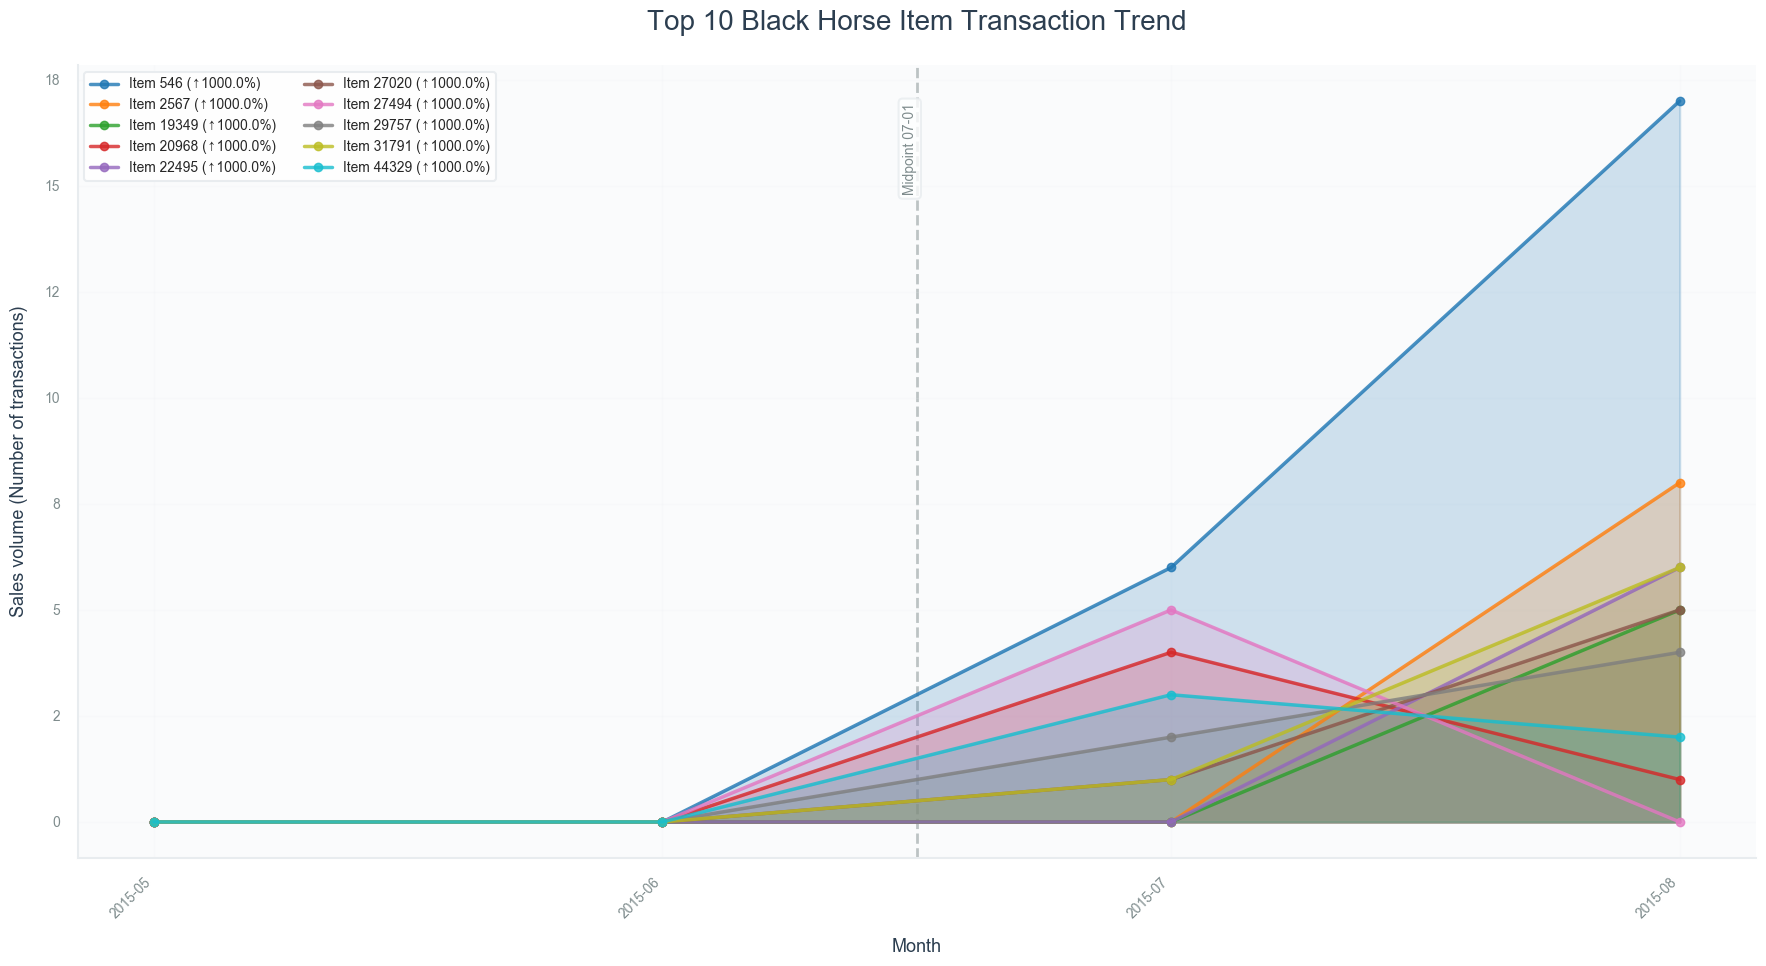


Top 10 黑马商品详细信息（分界点：7月1号，已排除九月份）:

1. Item 546:
   前半段平均销量: nan
   后半段平均销量: 11.50
   涨幅: 1000.00%
   总销量: 23

2. Item 2567:
   前半段平均销量: nan
   后半段平均销量: 8.00
   涨幅: 1000.00%
   总销量: 8

3. Item 19349:
   前半段平均销量: nan
   后半段平均销量: 5.00
   涨幅: 1000.00%
   总销量: 5

4. Item 20968:
   前半段平均销量: nan
   后半段平均销量: 2.50
   涨幅: 1000.00%
   总销量: 5

5. Item 22495:
   前半段平均销量: nan
   后半段平均销量: 6.00
   涨幅: 1000.00%
   总销量: 6

6. Item 27020:
   前半段平均销量: nan
   后半段平均销量: 3.00
   涨幅: 1000.00%
   总销量: 6

7. Item 27494:
   前半段平均销量: nan
   后半段平均销量: 5.00
   涨幅: 1000.00%
   总销量: 5

8. Item 29757:
   前半段平均销量: nan
   后半段平均销量: 3.00
   涨幅: 1000.00%
   总销量: 6

9. Item 31791:
   前半段平均销量: nan
   后半段平均销量: 3.50
   涨幅: 1000.00%
   总销量: 7

10. Item 44329:
   前半段平均销量: nan
   后半段平均销量: 2.50
   涨幅: 1000.00%
   总销量: 5


In [ ]:
# 绘制 Top-N 黑马商品（销量涨幅Top-N）的购买趋势
# 不考虑九月份数据，mid_point设置为7月1号
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

# 确保数据已加载
if 'merged' not in locals():
    merged = pd.read_csv('./archive/events_with_category.csv')
    merged['timestamp'] = pd.to_datetime(merged['timestamp'])

# 设置中文字体和样式
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 优雅配色
COLORS = {
    'primary': '#2E86AB',
    'primary_light': '#A23B72',
    'secondary': '#F18F01',
    'accent': '#C73E1D',
    'success': '#6A994E',
    'info': '#06A77D',
    'bg': '#FFFFFF',
    'bg_light': '#FAFBFC',
    'text': '#2C3E50',
    'text_light': '#7F8C8D',
    'grid': '#E8ECEF'
}

# 设置 Top N 数量
TOP_N = 10

# ==================== 1. 筛选交易数据并提取月份 ====================
transactions = merged[merged['event'] == 'transaction'].copy()
transactions['month'] = transactions['timestamp'].dt.to_period('M')

# 只排除九月份数据
transactions = transactions[~transactions['month'].astype(str).str.contains('2015-09')]

# ==================== 2. 计算每个商品每月的销量 ====================
monthly_sales = transactions.groupby(['itemid', 'month']).size().reset_index(name='sales_count')
monthly_sales['month'] = monthly_sales['month'].astype(str)

# ==================== 3. 计算销量涨幅 ====================
# 方法：比较前半段时间和后半段时间的平均销量
# mid_point设置为7月1号，即前半段：5月、6月，后半段：7月、8月
all_months = sorted([m for m in monthly_sales['month'].unique() if '2015-09' not in m])

# 设置分界点为7月1号（即7月及之后为后半段）
first_half_months = [m for m in all_months if m < '2015-07']
second_half_months = [m for m in all_months if m >= '2015-07']

# 找到7月在all_months中的索引位置，用于绘图
mid_point = len(first_half_months)

print(f'前半段月份: {first_half_months}')
print(f'后半段月份: {second_half_months}')

# 计算每个商品在前半段和后半段的平均销量
item_growth = []
for itemid in monthly_sales['itemid'].unique():
    item_data = monthly_sales[monthly_sales['itemid'] == itemid]
    
    first_half_sales = item_data[item_data['month'].isin(first_half_months)]['sales_count'].mean()
    second_half_sales = item_data[item_data['month'].isin(second_half_months)]['sales_count'].mean()
    
    # 计算涨幅（增长率）
    if first_half_sales > 0:
        growth_rate = ((second_half_sales - first_half_sales) / first_half_sales) * 100
    else:
        growth_rate = 1000 if second_half_sales > 0 else 0  # 如果前期为0，后期有销量，视为高增长
    
    # 计算总销量（用于筛选，只考虑有一定销量的商品）
    total_sales = item_data['sales_count'].sum()
    
    item_growth.append({
        'itemid': itemid,
        'first_half_avg': first_half_sales,
        'second_half_avg': second_half_sales,
        'growth_rate': growth_rate,
        'total_sales': total_sales
    })

growth_df = pd.DataFrame(item_growth)

# 筛选至少有5笔交易的商品（避免基数太小导致涨幅虚高）
growth_df = growth_df[growth_df['total_sales'] >= 5]

# 按涨幅排序，找出Top-N黑马商品
top_growth_items = growth_df.nlargest(TOP_N, 'growth_rate')['itemid'].tolist()

print(f'\nTop {TOP_N} Black Horse Item:')
print(growth_df.nlargest(TOP_N, 'growth_rate')[['itemid', 'first_half_avg', 'second_half_avg', 'growth_rate', 'total_sales']].to_string(index=False))

# ==================== 4. 绘制购买趋势图 ====================
fig, ax = plt.subplots(figsize=(18, 10), facecolor='white')
ax.set_facecolor(COLORS['bg_light'])

# 为每个商品分配颜色
colors = plt.cm.tab10(np.linspace(0, 1, len(top_growth_items)))

# 绘制每个黑马商品的月度购买趋势
for idx, itemid in enumerate(top_growth_items):
    item_monthly = monthly_sales[monthly_sales['itemid'] == itemid].copy()
    item_monthly = item_monthly.sort_values('month')
    
    # 确保所有月份都有数据（缺失的月份填充0），但排除九月份
    all_months_df = pd.DataFrame({'month': all_months})
    item_monthly = all_months_df.merge(item_monthly, on='month', how='left')
    item_monthly['sales_count'] = item_monthly['sales_count'].fillna(0)
    item_monthly = item_monthly.sort_values('month')
    
    # 获取涨幅信息用于标签
    growth_info = growth_df[growth_df['itemid'] == itemid].iloc[0]
    growth_rate = growth_info['growth_rate']
    
    # 绘制趋势线
    ax.plot(item_monthly['month'], item_monthly['sales_count'], 
           marker='o', linewidth=2.5, markersize=6, 
           color=colors[idx], alpha=0.8, 
           label=f'Item {int(itemid)} (↑{growth_rate:.1f}%)')
    
    # 添加填充区域
    ax.fill_between(item_monthly['month'], 0, item_monthly['sales_count'], 
                   alpha=0.2, color=colors[idx])

# 添加分界线（7月1号，即前半段和后半段的分界）
if len(all_months) > 1 and mid_point > 0:
    ax.axvline(x=mid_point - 0.5, color=COLORS['text_light'], 
              linestyle='--', linewidth=2, alpha=0.5, zorder=0)
    ax.text(mid_point - 0.5, ax.get_ylim()[1] * 0.95, 'Midpoint 07-01', 
           rotation=90, ha='right', va='top', fontsize=10, 
           color=COLORS['text_light'], bbox=dict(boxstyle='round', 
           facecolor='white', alpha=0.8, edgecolor=COLORS['grid']))

# 美化坐标轴
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(COLORS['grid'])
ax.spines['bottom'].set_color(COLORS['grid'])
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# 设置x轴标签
ax.set_xticks(range(len(all_months)))
ax.set_xticklabels(all_months, rotation=45, ha='right', fontsize=10, color=COLORS['text_light'])

ax.set_xlabel('Month', fontsize=13, color=COLORS['text'], fontweight='500', labelpad=12)
ax.set_ylabel('Sales volume (Number of transactions)', fontsize=13, color=COLORS['text'], fontweight='500', labelpad=12)
ax.set_title(f'Top {TOP_N} Black Horse Item Transaction Trend', 
            fontsize=20, fontweight='600', color=COLORS['text'], pad=25)
ax.grid(True, alpha=0.15, linestyle='-', linewidth=0.8, color=COLORS['grid'])
ax.tick_params(colors=COLORS['text_light'], labelsize=10)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))

# 图例
ax.legend(loc='upper left', fontsize=10, framealpha=0.95, 
         edgecolor=COLORS['grid'], ncol=2)

plt.tight_layout()
plt.show()

# 打印详细信息
print(f'\nTop {TOP_N} 黑马商品详细信息（分界点：7月1号，已排除九月份）:')
for idx, itemid in enumerate(top_growth_items, 1):
    item_data = monthly_sales[monthly_sales['itemid'] == itemid]
    growth_info = growth_df[growth_df['itemid'] == itemid].iloc[0]
    print(f'\n{idx}. Item {int(itemid)}:')
    print(f'   前半段平均销量: {growth_info["first_half_avg"]:.2f}')
    print(f'   后半段平均销量: {growth_info["second_half_avg"]:.2f}')
    print(f'   涨幅: {growth_info["growth_rate"]:.2f}%')
    print(f'   总销量: {int(growth_info["total_sales"])}')